In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from category_encoders import MEstimateEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')

/kaggle/input/housedata/output.csv
/kaggle/input/housedata/data.csv
/kaggle/input/housedata/data.dat


## Data Observation, Cleaning

In [2]:
df = pd.read_csv('/kaggle/input/housedata/data.csv')
df_house = df.copy()

df_house

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,3.130000e+05,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2.384000e+06,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,3.420000e+05,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,4.200000e+05,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,5.500000e+05,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,2014-07-09 00:00:00,3.081667e+05,3.0,1.75,1510,6360,1.0,0,0,4,1510,0,1954,1979,501 N 143rd St,Seattle,WA 98133,USA
4596,2014-07-09 00:00:00,5.343333e+05,3.0,2.50,1460,7573,2.0,0,0,3,1460,0,1983,2009,14855 SE 10th Pl,Bellevue,WA 98007,USA
4597,2014-07-09 00:00:00,4.169042e+05,3.0,2.50,3010,7014,2.0,0,0,3,3010,0,2009,0,759 Ilwaco Pl NE,Renton,WA 98059,USA
4598,2014-07-10 00:00:00,2.034000e+05,4.0,2.00,2090,6630,1.0,0,0,3,1070,1020,1974,0,5148 S Creston St,Seattle,WA 98178,USA


In [3]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

In [4]:
df_house.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261
std,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000
50%,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000
75%,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000


In [5]:
df_house.isnull().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

In [6]:
df_house.duplicated().sum()

0

In [7]:
df_house['condition'].value_counts()

condition
3    2875
4    1252
5     435
2      32
1       6
Name: count, dtype: int64

In [8]:
df_house['view'].value_counts()

view
0    4140
2     205
3     116
4      70
1      69
Name: count, dtype: int64

### EDA

In [9]:
# Visualize Price Distirbution

fig = px.histogram(df_house,
                  x = 'price',
                  marginal = 'box',
                  title = 'House Price Distribution')
fig.update_layout(bargap = 0.1, width = 1000, height = 600)
fig.show()

In [10]:
# Visualize Price by Condition

fig = px.histogram(df_house,
                  x = 'price',
                  marginal = 'box',
                  color = 'condition',
                  title = 'House Price by Condition')
fig.update_layout(bargap = 0.1,width = 1200, height = 600)
fig.show()

In [11]:
fig = px.scatter(df_house, 
                 x='sqft_lot', 
                 y='price',
                 title='Price vs. Square Footage of Lot')
fig.update_traces(marker = dict(color = 'green'))
fig.update_layout(xaxis_title='Square Footage of Lot', yaxis_title='Price',
                 width = 1200, height = 600)
fig.show()

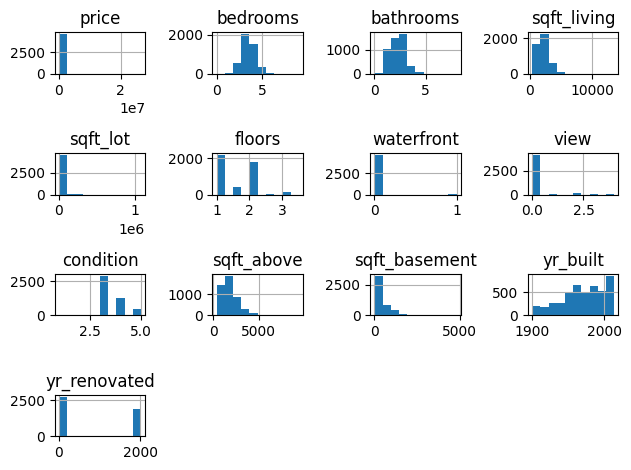

In [12]:
df_house.hist()
plt.tight_layout()

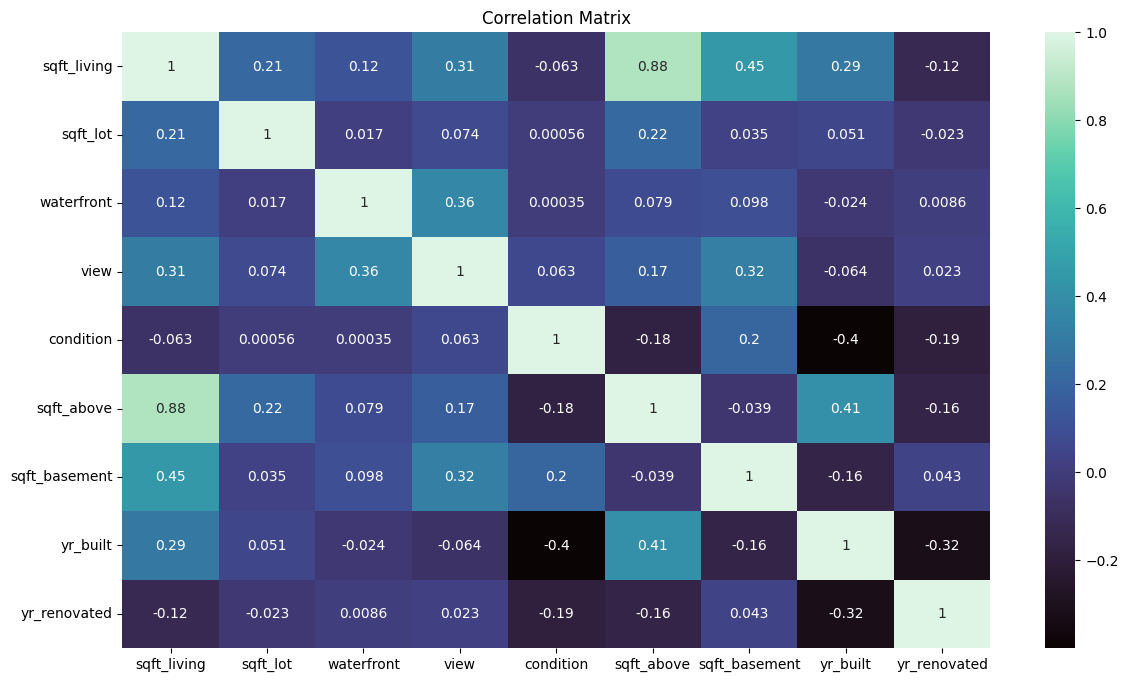

In [13]:
numeric_columns = df_house.select_dtypes('int64', 'float64')
corr_matrix = numeric_columns.corr()

plt.figure(figsize =(14,8))
sns.heatmap(corr_matrix, annot = True, cmap = 'mako')
plt.title('Correlation Matrix')
plt.show()

## Data Preprocessing

In [14]:
# Interquartile Range (IQR) function to remove outliars

data_numeric = df_house.select_dtypes(exclude='object')

for col in data_numeric.columns:
    q1 = data_numeric[col].quantile(0.25)
    q3 = data_numeric[col].quantile(0.75)
    iqr = q3 - q1
    low = q1 - (1.5 * iqr)
    high = q3 + (1.5 * iqr)
    
    # Count outliers
    outliers = ((data_numeric[col] > high) | (data_numeric[col] < low)).sum()
    total = data_numeric.shape[0]
    print(f"Total outliers in {col} are: {outliers} - {round(100 * (outliers / total), 2)}%")
    
    if outliers > 0:
        # Filter data to exclude outliers
        df_house = df_house.loc[(df_house[col] <= high) & (df_house[col] >= low)]

Total outliers in price are: 240 - 5.22%
Total outliers in bedrooms are: 118 - 2.57%
Total outliers in bathrooms are: 141 - 3.07%
Total outliers in sqft_living are: 129 - 2.8%
Total outliers in sqft_lot are: 541 - 11.76%
Total outliers in floors are: 0 - 0.0%
Total outliers in waterfront are: 33 - 0.72%
Total outliers in view are: 460 - 10.0%
Total outliers in condition are: 6 - 0.13%
Total outliers in sqft_above are: 116 - 2.52%
Total outliers in sqft_basement are: 82 - 1.78%
Total outliers in yr_built are: 0 - 0.0%
Total outliers in yr_renovated are: 0 - 0.0%


In [15]:
df_train = df_house.drop(['date', 'country'], axis = 1)
df_train

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip
0,313000.000000,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133
2,342000.000000,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042
3,420000.000000,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008
4,550000.000000,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052
5,490000.000000,2.0,1.00,880,6380,1.0,0,0,3,880,0,1938,1994,522 NE 88th St,Seattle,WA 98115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,308166.666667,3.0,1.75,1510,6360,1.0,0,0,4,1510,0,1954,1979,501 N 143rd St,Seattle,WA 98133
4596,534333.333333,3.0,2.50,1460,7573,2.0,0,0,3,1460,0,1983,2009,14855 SE 10th Pl,Bellevue,WA 98007
4597,416904.166667,3.0,2.50,3010,7014,2.0,0,0,3,3010,0,2009,0,759 Ilwaco Pl NE,Renton,WA 98059
4598,203400.000000,4.0,2.00,2090,6630,1.0,0,0,3,1070,1020,1974,0,5148 S Creston St,Seattle,WA 98178


In [16]:
# Split data into x , y

x = df_train.drop('price', axis = 1)
y = df_train['price']

In [17]:
# Implement MEstimateEncoder to change obj to binary

object_cols = df_train.select_dtypes(include = ['object']).columns.tolist()

MEncoder = MEstimateEncoder(cols=object_cols, m = 0.5)
x = MEncoder.fit_transform(x,y)

In [18]:
# Implement train test split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state= 42, shuffle=True)

In [19]:
scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

## Data Modelling, Prediction

#### Linear Regression Model

In [20]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [21]:
lr_pred = lr.predict(x_test)
lr_plot = pd.DataFrame({'Actual Value': y_test, 'Predicted Value': lr_pred})

lr_plot.head()

,Actual Value,Predicted Value
3860,300000.0,292601.507026
71,783500.0,765072.805073
749,263000.0,257893.841744
4354,0.0,1798.682887
2632,473000.0,460832.135655


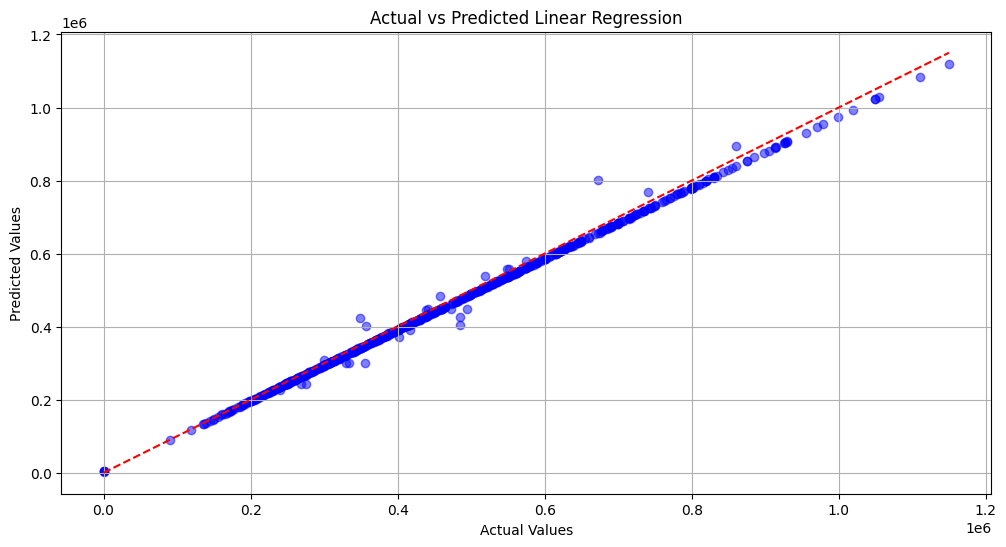

In [22]:
plt.figure(figsize = (12, 6))
plt.scatter(y_test, lr_pred, color = 'blue', alpha = 0.5)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], color = 'red', linestyle = '--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Linear Regression')
plt.grid()

In [23]:
# LR Model Matrics

lr_r2 = r2_score(y_test, lr_pred)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_mae = mean_absolute_error(y_test, lr_pred)

### Random Forest Model

In [24]:
rf = RandomForestRegressor(n_estimators = 400)
rf.fit(x_train, y_train)

RandomForestRegressor(n_estimators=400)

In [25]:
rf_pred = rf.predict(x_test)
rf_plot = pd.DataFrame({'Actual Values': y_test, 'Predicted Valus': rf_pred})

rf_plot.head()

,Actual Values,Predicted Valus
3860,300000.0,298479.621786
71,783500.0,764963.675000
749,263000.0,256875.422500
4354,0.0,208.250000
2632,473000.0,462978.750000


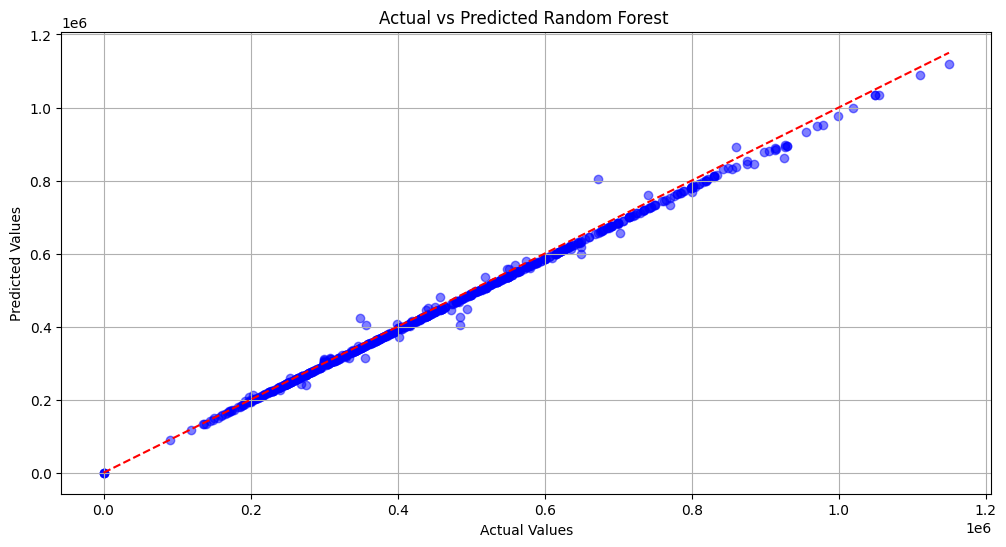

In [26]:
plt.figure(figsize = (12, 6))
plt.scatter(y_test, rf_pred, color = 'blue', alpha = 0.5)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], color = 'red', linestyle = '--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Random Forest ')
plt.grid()

In [27]:
# RF Model Matrics

rf_r2 = r2_score(y_test, rf_pred)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

### XGBoost

In [28]:
xg = XGBRegressor()
xg.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [29]:
xg_pred = xg.predict(x_test)

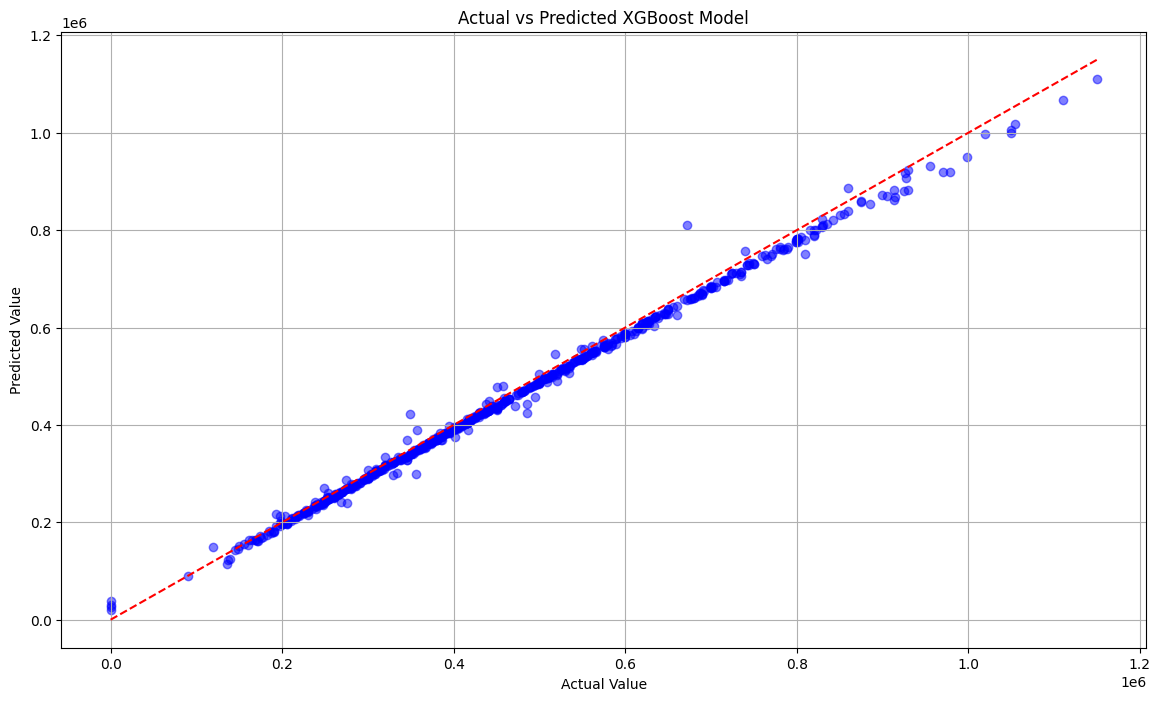

In [30]:
plt.figure(figsize=(14,8))
plt.scatter(y_test, xg_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Actual vs Predicted XGBoost Model')
plt.grid(True)
plt.show()

In [31]:
xg_r2 = r2_score(y_test, xg_pred)
xg_mse = mean_squared_error(y_test, xg_pred)
xg_mae = mean_absolute_error(y_test, xg_pred)

## Model Evaluation

In [32]:
models = ['Linear Regression','Random Forest', 'XGBoost']
data = [[lr_r2,lr_mse, lr_mae],[rf_r2, rf_mse, rf_mae], [xg_r2, xg_mse, xg_mae]]
cols = ['R2','MSE','MAE']
pd.DataFrame(data, columns = cols, index = models).sort_values(ascending = False, by ='R2')

,R2,MSE,MAE
Linear Regression,0.994729,2.064044e+08,11457.533769
Random Forest,0.994461,2.169337e+08,11587.570321
XGBoost,0.993065,2.715932e+08,13027.552174
